In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.

import kagglehub
import os

# Download the first dataset (Daniel Shanbalico's)
danielshanbalico_dog_emotion_path = kagglehub.dataset_download('danielshanbalico/dog-emotion')

# Download the second dataset (Dev Zohaib's Dog Emotions Prediction)
devzohaib_dog_emotion_path = kagglehub.dataset_download('devzohaib/dog-emotions-prediction')

print("First dataset path:", danielshanbalico_dog_emotion_path)
print("Files inside:", os.listdir(danielshanbalico_dog_emotion_path))

print("\nSecond dataset path:", devzohaib_dog_emotion_path)
print("Files inside:", os.listdir(devzohaib_dog_emotion_path))

print('Data source import complete.')


100%|██████████| 155M/155M [00:02<00:00, 79.5MB/s]

Extracting files...


100%|██████████| 379M/379M [00:03<00:00, 108MB/s]

Extracting files...


First dataset path: /root/.cache/kagglehub/datasets/danielshanbalico/dog-emotion/versions/1
Files inside: ['Dog Emotion']

Second dataset path: /root/.cache/kagglehub/datasets/devzohaib/dog-emotions-prediction/versions/1
Files inside: ['images']
Data source import complete.


<div style="padding: 10px;
            background-color: #9999CC;
            border-radius: 2px;">
    <h1 style="color: #9F8170; font-size: 45px !important;
              font-family: Calibri;
              text-transform: uppercase;
              text-shadow: 0.5px 1px 0.4px #674832,
                           1px 2px 0.4px #674832,
                           1.5px 3px 0.4px #674832,
                           2px 4px 0.4px #674832,
                           2.5px 5px 0.4px #674832,
                           3px 6px 0.4px #674832,
                           3px 10px 5px rgba(16, 16, 16, 0.5),
                           3px 15px 10px rgba(16, 16, 16, 0.4),
                           3px 20px 30px rgba(16, 16, 16, 0.3);">
        🐶 Dog Emotions Classifier 🐕
    </h1>
</div>


<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">0. |</b><p style="font-size: 25px !important; display: inline-block;">Overview</p>
    </h2>
</div>


<div style="padding: 10px">
    <p style="font-size: 17px !important;
             font-family: Calibri;
             font-shadow: 0.5px 0.5px 0.5px;">In this notebook, we will take a brief look at the dataset and build the model that will classify the dog's emotions from the picture. We will use deep learning convolutional neural network (CNN) as a classifier.<br><br>
        Deep learning is a class of machine learning algorithms that uses multiple layers to progressively extract higher-level features from the raw input. For example, in image processing, lower layers may identify edges, while higher layers may identify the concepts relevant to a human such as digits or letters or faces.<br>
more: <a href="https://en.wikipedia.org/wiki/Deep_learning">https://en.wikipedia.org/wiki/Deep_learning</a><br>
<br>
CNN - In deep learning, a convolutional neural network is a class of artificial neural network, most commonly applied to analyze visual imagery.<br>
more: <a href="https://en.wikipedia.org/wiki/Convolutional_neural_network">https://en.wikipedia.org/wiki/Convolutional_neural_network</a><br>
<br>
P.S.: I would be happy to read comments with suggestions on what could be improved or changed :)</p>
</div>


<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">1. |</b><p style="font-size: 25px !important; display: inline-block;">Imports</p>
    </h2>
</div>

In [ ]:
# math and tables
import pandas as pd
import numpy as np

# for model building
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
tf.random.set_seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# visualization libraries
import cv2
import matplotlib.pyplot as plt

# some utils
from sklearn.model_selection import train_test_split
from random import randint

Num GPUs Available:  1



<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">2. |</b><p style="font-size: 25px !important; display: inline-block;">Data Loading and Formatting</p>
    </h2>
</div>


<div style="padding: 10px">
    <p style="font-size: 17px !important;
             font-family: Calibri;
             font-shadow: 0.5px 0.5px 0.5px;">There are 4 classes: angry, happy, relaxed, sad. File "labels.csv" contains the file path location of each image and their labels. Images will be resized in process of loading. The size is stored in the variable img_size.</p>
</div>

In [ ]:
# Paths to both datasets
data_paths = [
    "/root/.cache/kagglehub/datasets/danielshanbalico/dog-emotion/versions/1/Dog Emotion/",
    os.path.join(devzohaib_dog_emotion_path, "images")  # ✅ Fix: Include "images" subfolder
]

# ✅ Get only directories (ignore files like labels.csv)
class_names = [name for name in sorted(os.listdir(data_paths[0])) if os.path.isdir(os.path.join(data_paths[0], name))]
num_classes = len(class_names)

img_size = (192, 192)  # ✅ Only height & width (no channels needed for grayscale)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')

# Initialize lists for images and labels
images = []
labels = []
total_images = 0  # Track total images loaded

# ✅ Process both datasets in a single loop
for data_path in data_paths:
    for label in class_names:  # Loop through each class
        label_path = os.path.join(data_path, label)
        if os.path.exists(label_path):  # Ensure the class folder exists
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # ✅ Load as grayscale
                if img is not None:
                    img = cv2.resize(img, img_size)  # ✅ No need for channel conversion
                    images.append(img)

                    # One-hot encode labels
                    label_vec = np.zeros(num_classes)
                    label_vec[class_names.index(label)] = 1
                    labels.append(label_vec)

                    total_images += 1  # ✅ Count images

print(f'Loaded {total_images} images from both datasets')

# Convert lists to NumPy arrays
labels = np.asarray(labels)
images = np.asarray(images)

# ✅ Reshape images for CNN (add channel dimension)
images = images.reshape(-1, img_size[0], img_size[1], 1)  # (num_samples, height, width, 1)

print(f'\nFinal dataset shape:\nImages: {images.shape}, Labels: {labels.shape}')


4 classes: ['angry', 'happy', 'relaxed', 'sad']
image size: (192, 192)
Loaded 19921 images from both datasets

Final dataset shape:
Images: (19921, 192, 192, 1), Labels: (19921, 4)



<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">3. |</b><p style="font-size: 25px !important; display: inline-block;">Display Pictures</p>
    </h2>
</div>

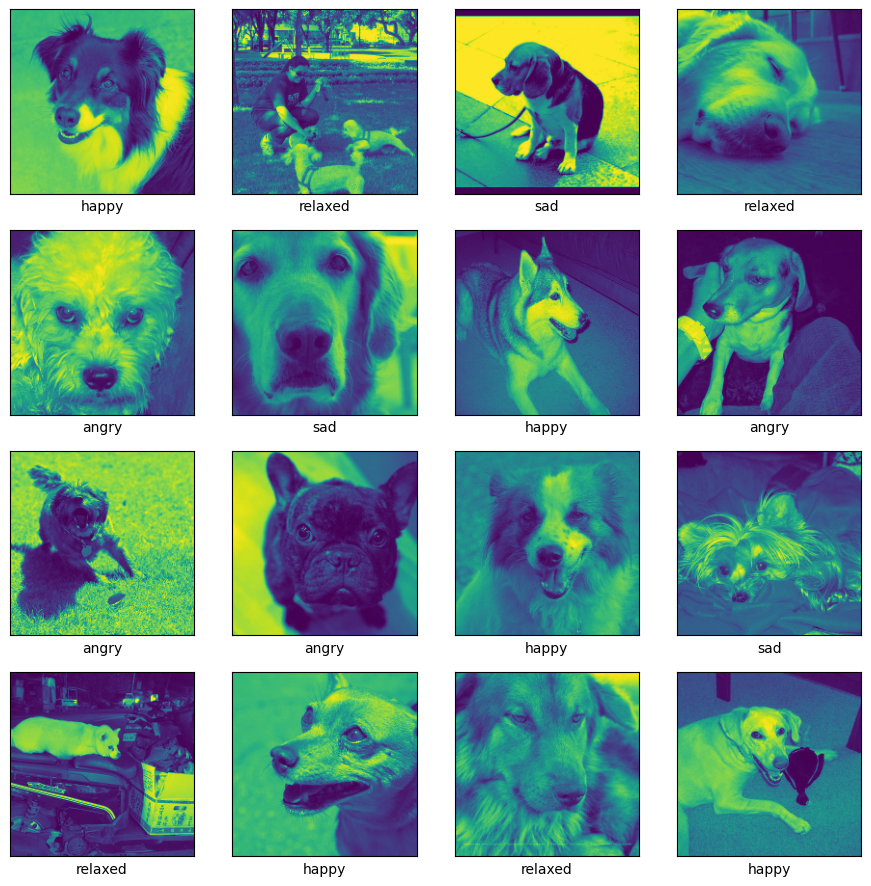

In [ ]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(11, 11))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images) - 1)


        axs[x][y].imshow(images[i])

        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])

plt.show()


<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">4. |</b><p style="font-size: 25px !important; display: inline-block;">Train/Test Split</p>
    </h2>
</div>

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (16932, 192, 192, 1)
train labels shape: (16932, 4)

validation images shape: (2989, 192, 192, 1)
validation labels shape: (2989, 4)




<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">5. |</b><p style="font-size: 25px !important; display: inline-block;">CNN Model</p>
    </h2>
</div>

<img src="https://datastart.ru/blog/assets/uploads/eeugdrKO7SxHIC5MsIYVb51BWMgY4uPV.jpg" alt="">


<div style="padding: 10px">
    <p style="font-size: 17px !important;
             font-family: Calibri;
             font-shadow: 0.5px 0.5px 0.5px;">The cnn_model will consist of an input rescaling layer, 4 convolution layers blocks and 4 dense layers after them. Input rescaling layer, which converts the values into a format from 0 to 1. The block of convolution layers contains 2 convolution layers and 1 max pooling layer after them (+ global average pooling if it is a jump from convolutional layers to dense). And the output dense layer contains as many neurons as there are classes. <br>
        We will use softmax as the output activation function (the sum of its outputs == 1), because the problem is of an exclusive classification (that is, the dog cannot be both angry and happy at the same time).<br><br>
    more: <a href="https://en.wikipedia.org/wiki/Softmax_function" rel=" noreferrer nofollow">https://en.wikipedia.org/wiki/Softmax_function</a>.</p>
</div>

**Removed 1 convolutional block with 512 filters to reduce overfitting**

**Added dropouts: nn_model.add(Dropout(0.5))**

**Added the data augmentor below**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Create a Data Augmentation generator (Balanced & Efficient)
datagen = ImageDataGenerator(
    rotation_range=15,       # Rotate images by up to 15 degrees (not too extreme)
    width_shift_range=0.05,  # Shift width by 5% instead of 10%
    height_shift_range=0.05, # Shift height by 5% instead of 10%
    horizontal_flip=True,    # Randomly flip images horizontally
    zoom_range=0.15          # Reduce zoom variation slightly
)

# ✅ Use `.flow()` to apply augmentation on-the-fly (NO `.fit(X_train)`)
train_generator = datagen.flow(X_train, y_train, batch_size=32)



In [ ]:
cnn_model = tf.keras.Sequential()

# Inputs and rescaling
cnn_model.add(tf.keras.layers.Rescaling(scale=1. / 255, input_shape=(192, 192, 1)))

# Convolutional block 1
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
#cnn_model.add(Dropout(0.5))  # Dropout to prevent overfitting

# Convolutional block 2
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
#cnn_model.add(Dropout(0.5))

# Convolutional block 3
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
#cnn_model.add(Dropout(0.5))

# 🚀 Re-Added Convolutional Block 4
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
#cnn_model.add(Dropout(0.5))  # Extra dropout for deeper layers

# 🚀 Fix: Flatten before Dense layers
cnn_model.add(tf.keras.layers.Flatten())  # Converts feature maps to 1D

# Dense block (Fully connected layers)
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))

# 🚀 Fix: Move Softmax to the end (output layer)
cnn_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 192, 192, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 192, 192, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 192, 192, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 96, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 48, 48, 256)         │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 512)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 512)         │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,019,780 (80.18 MB)

 Trainable params: 21,019,780 (80.18 MB)

 Non-trainable params: 0 (0.00 B)


<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">6. |</b><p style="font-size: 25px !important; display: inline-block;">Model Training</p>
    </h2>
</div>

In [ ]:
# creating ModelChecpoint callback
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}.keras', save_best_only=True)


In [ ]:
history = cnn_model.fit(train_generator,  # ✅ Uses augmented data instead of raw X_train
                        epochs=25,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpoint_callback])


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 176s 291ms/step - accuracy: 0.2887 - loss: 1.3896 - val_accuracy: 0.3289 - val_loss: 1.3463
Epoch 2/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 135s 255ms/step - accuracy: 0.3237 - loss: 1.3486 - val_accuracy: 0.3275 - val_loss: 1.3375
Epoch 3/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 142s 268ms/step - accuracy: 0.3349 - loss: 1.3401 - val_accuracy: 0.3640 - val_loss: 1.3235
Epoch 4/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 134s 252ms/step - accuracy: 0.3639 - loss: 1.3260 - val_accuracy: 0.3720 - val_loss: 1.3392
Epoch 5/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 144s 271ms/step - accuracy: 0.3749 - loss: 1.3174 - val_accuracy: 0.3961 - val_loss: 1.2986
Epoch 6/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 135s 255ms/step - accuracy: 0.3768 - loss: 1.3105 - val_accuracy: 0.3958 - val_loss: 1.2836
Epoch 7/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 146s 263ms/step - accuracy: 0.3985 - loss: 1.2885 - val_accuracy: 0.4062 - val_loss: 1.2821
Epoch 8/25
530/530 ━━━━━━━━━━━━━━━━━━━━ 133s 251ms/step - accuracy: 0.4005 - loss: 1.28


<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">7. |</b><p style="font-size: 25px !important; display: inline-block;">Accuracy and Loss Plot</p>
    </h2>
</div>

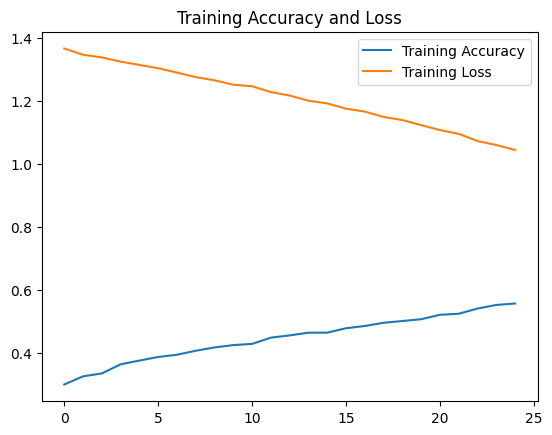

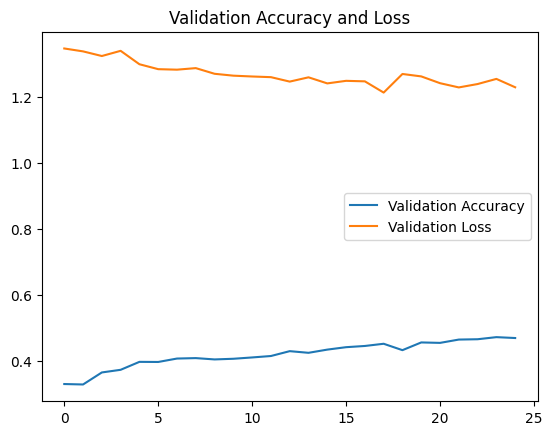

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()


<div style="padding: 10px">
    <h2 class="h2-title" style="color: black; font-size: 25px !important;
              font-family: Calibri;">
        <b style="color: #00FF66; display: inline-block; font-size: 25px !important;">8. |</b><p style="font-size: 25px !important; display: inline-block;">Predictions</p>
    </h2>
</div>

In [ ]:
fig, axs = plt.subplots(7, 4, figsize=(15, 15))

i = 0
for x in range(7):
    for y in range(4):
        prediction = cnn_model.predict(X_val[i][None, ...], verbose=0)[0]

        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')

        axs[x][y].imshow(X_val[i])

        i += 1
plt.show()